In [2]:
def brute_froce_LOO(X_train, y_train, X_test, y_test, idx_list, ap_baseline):

    print("Brute Force LOO Running...")
   
    records = []
    for i in idx_list:   
        mask = np.ones(X_train.shape[0], dtype=bool)
        mask[i] = False
        X_tr, y_tr = X_train[mask], y_train[mask]

        rf = RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)
        rf.fit(X_tr, y_tr)
        proba = rf.predict_proba(X_test)[:, 1]
        ap_loo = average_precision_score(y_test, proba)
        impact = ap_baseline - ap_loo

        records.append({"train_idx": i, "AP_full": ap_baseline, "AP_LOO": ap_loo, "Impact": impact})
        print(f"Removed train idx {i} | AP_LOO={ap_loo:.4f} | Impact={impact:+.4f}")

    df = pd.DataFrame(records).sort_values(by="Impact", ascending=False).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(df)), df["Impact"])
    plt.xticks(range(len(df)), df["train_idx"].astype(str), rotation=45, ha="right")
    plt.ylabel("Impact (AP_full - AP_LOO)")
    plt.title("LOO Impact on AP using RandomForest")
    plt.tight_layout()
    plt.show()

    print("\nBrute Force LOO Result")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    return df

In [3]:
def confusion_matrix_plot(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation="nearest", cmap="Blues")

    ticks = np.arange(len(labels))
    ax.set_xticks(ticks); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks(ticks); ax.set_yticklabels(labels)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    fig.tight_layout()
    plt.show()

In [4]:
def pr_curve_binary(y_true, proba, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, lw=2, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return ap

In [5]:
def roc_curve_binary(y_true, proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, proba)
    auc = roc_auc_score(y_true, proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return auc


In [6]:
def train_eval(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")

    print(f"\n{model_name} is trained and evaluated")
    print(f"Accuracy: {acc:.4f} | F1(macro): {f1m:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Legit", "Phishing"], digits=4))

    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    ap = average_precision_score(y_test, proba) if proba is not None else np.nan
    rocauc = roc_auc_score(y_test, proba) if proba is not None else np.nan
    print(f"AP(PR-AUC): {ap:.4f} | ROC-AUC: {rocauc:.4f}")

    return (model_name, y_pred, proba, acc, f1m, ap, rocauc)


KNN is trained and evaluated
Accuracy: 0.9396 | F1(macro): 0.9388
              precision    recall  f1-score   support

       Legit     0.9301    0.9339    0.9320      1225
    Phishing     0.9472    0.9441    0.9457      1539

    accuracy                         0.9396      2764
   macro avg     0.9386    0.9390    0.9388      2764
weighted avg     0.9396    0.9396    0.9396      2764

AP(PR-AUC): 0.9850 | ROC-AUC: 0.9850

Logistic Regression is trained and evaluated
Accuracy: 0.9287 | F1(macro): 0.9278
              precision    recall  f1-score   support

       Legit     0.9186    0.9208    0.9197      1225
    Phishing     0.9368    0.9350    0.9359      1539

    accuracy                         0.9287      2764
   macro avg     0.9277    0.9279    0.9278      2764
weighted avg     0.9287    0.9287    0.9287      2764

AP(PR-AUC): 0.9851 | ROC-AUC: 0.9815

SVC is trained and evaluated
Accuracy: 0.9541 | F1(macro): 0.9533
              precision    recall  f1-score   support



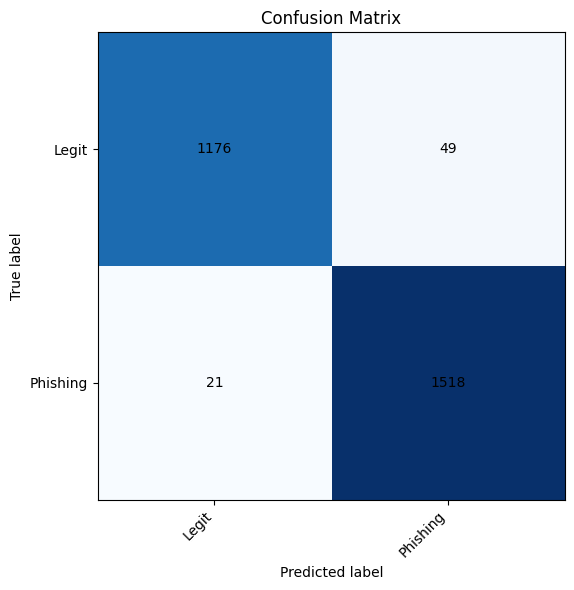

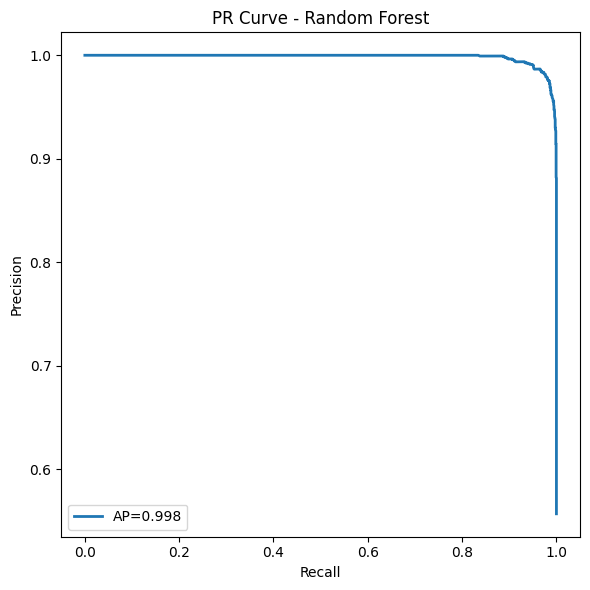

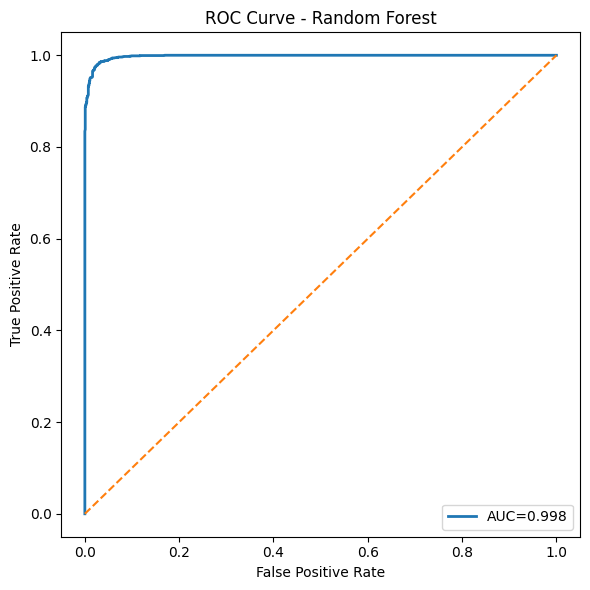

Brute Force LOO Running...
Removed train idx 0 | AP_LOO=0.9982 | Impact=+0.0000
Removed train idx 799 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 1599 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 2399 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 3199 | AP_LOO=0.9982 | Impact=+0.0000
Removed train idx 3999 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 4799 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 5599 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 6399 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 7199 | AP_LOO=0.9983 | Impact=+0.0000


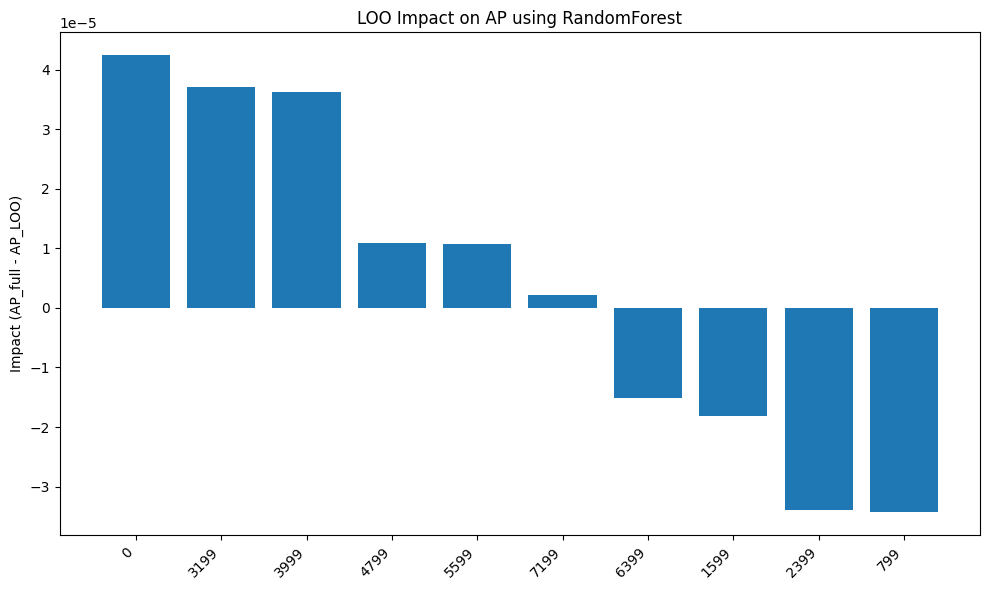


Brute Force LOO Result
 train_idx  AP_full  AP_LOO  Impact
         0   0.9983  0.9982  0.0000
      3199   0.9983  0.9982  0.0000
      3999   0.9983  0.9983  0.0000
      4799   0.9983  0.9983  0.0000
      5599   0.9983  0.9983  0.0000
      7199   0.9983  0.9983  0.0000
      6399   0.9983  0.9983 -0.0000
      1599   0.9983  0.9983 -0.0000
      2399   0.9983  0.9983 -0.0000
       799   0.9983  0.9983 -0.0000


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def main():
   
    phishing_websites = fetch_ucirepo(id=327)  
    X = phishing_websites.data.features.values
    y = phishing_websites.data.targets.values.ravel() 
    y = np.where(y == -1, 0, 1)
    labels = ["Legit", "Phishing"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    

    # Standardize numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    models = [
        ("KNN", KNeighborsClassifier(n_neighbors=15)),
        ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=7, class_weight="balanced")),
        ("SVC", SVC(kernel="rbf", probability=True, random_state=7, class_weight="balanced")),
        ("Random Forest", RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)),
    ]

    results = []
    for name, model in models:
        results.append(train_eval(name, model, X_train_scaled, X_test_scaled, y_train, y_test))

    best = max(results, key=lambda t: t[5])

    print(f"Best by AP: {best[0]} | AP={best[5]:.4f}")
    best_model_name, best_pred, best_proba, best_acc, best_f1m, best_ap, best_rocauc = best
    print(f"\nBest model by AP: {best_model_name} | AP={best_ap:.4f} | F1m={best_f1m:.4f} | Acc={best_acc:.4f}")

    confusion_matrix_plot(y_test, best_pred, labels)

    pr_curve_binary(y_test, best_proba, title=f"PR Curve - {best_model_name}")
    roc_curve_binary(y_test, best_proba, title=f"ROC Curve - {best_model_name}")

    idx_list = [0, 799, 1599, 2399, 3199, 3999, 4799, 5599, 6399, 7199]
    brute_froce_LOO(X_train_scaled, y_train, X_test_scaled, y_test, idx_list, best_ap)

if __name__ == "__main__":
    main()